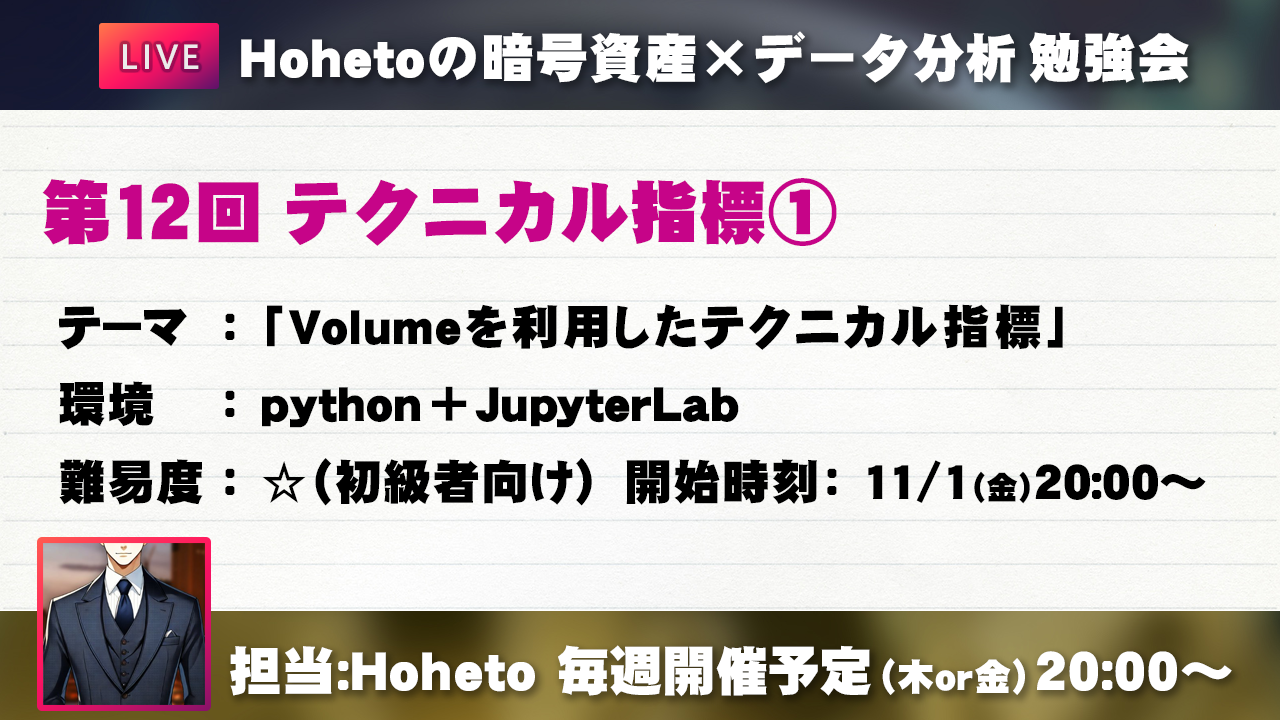

In [1]:
from IPython.display import Image

Image('./images/12_00.png')

# Hoheto勉強会 第12回 Volumeを利用したテクニカル指標

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- テクニカル指標の分析を行います。
- Volumeを利用したテクニカルは大衆心理を反映している可能性があり、使える可能性があります。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆ 1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

plt.rcParams['axes.axisbelow'] = True

In [5]:
import pickle

def dump_pickle(obj, path):
    with open(path, mode="wb") as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, mode="rb") as f:
        data = pickle.load(f)
        return data

# データ取得

## ビットコインデータの取得(Binance USDM)

- 価格データ取得用関数。

In [6]:
from dateutil import parser

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        api = apis[exchange]
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        if start_time > to_time:
            break
        time.sleep(0.2)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df = df[from_date:to_date]
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df

- 相関プロット用関数。

In [7]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

- 価格データ取得。
- 今回は取引量の多いBinanceのBTCUSDT（デリバティブ、USDM）を利用します。

In [8]:
apis = {
    'binance': ccxt.binanceusdm(),
}

In [9]:
btcusdt = fetch_ohlcv('binance', 'BTC/USDT:USDT', '2019-10-01', '2024-10-30', '1d')

In [10]:
btcusdt

,binance_open,binance_high,binance_low,binance_close,binance_volume,binance_ror
timestamp,,,,,,
2019-10-01 00:00:00+00:00,8285.31,8499.00,8171.00,8290.00,39212.804,0.000566
2019-10-02 00:00:00+00:00,8290.00,8365.92,8149.35,8352.14,30329.179,0.007496
2019-10-03 00:00:00+00:00,8353.40,8386.00,8020.00,8220.27,33430.230,-0.015937
2019-10-04 00:00:00+00:00,8219.95,8227.42,7979.95,8130.56,28421.111,-0.010875
2019-10-05 00:00:00+00:00,8130.00,8175.00,8010.00,8122.14,30262.006,-0.000967
...,...,...,...,...,...,...
2024-10-26 00:00:00+00:00,66662.70,67450.00,66414.10,67071.80,94169.992,0.006137
2024-10-27 00:00:00+00:00,67071.90,68306.10,66909.40,67992.60,88468.808,0.013727
2024-10-28 00:00:00+00:00,67992.70,70331.00,67584.20,69940.00,256128.622,0.028640


# 元ネタ

- 海外のユーザーのツイート。
- 複数のVolume系テクニカル指標を組み合わせて、良好な結果を得られる、というもの。

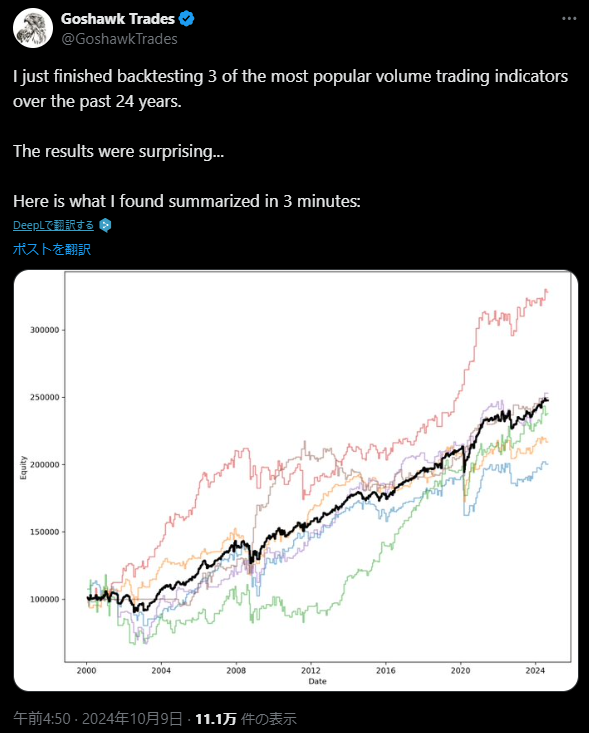

In [11]:
Image('./images/12_01.png', width=500)

# オンバランスボリューム(OBV)

- オンバランスボリューム(OBV)とは
  - ボリュームと価格の変化を関連付ける累積指標。
  - シンボルが前日の終値よりも高く終値した場合、その日の取引量はすべて上昇取引量とみなされ、下降取引量の逆の場合は下降取引量とみなされます。
  - OBV は反転の先行指標として使用できる、とのこと。

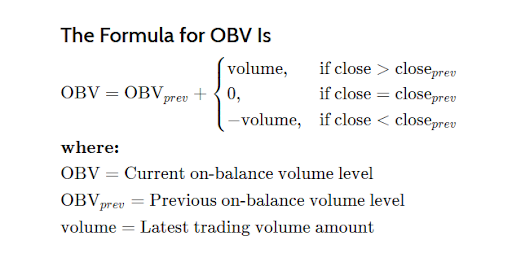

In [12]:
Image('./images/12_02_01.png', width=500)

## 指標の計算

In [13]:
strategy1 = btcusdt.copy()

In [14]:
# 当日リターンの符号と、当日Volumeを掛け合わせる
strategy1['daily_obv'] = np.sign(strategy1['binance_ror']) * strategy1['binance_volume']
# cumsumしたものがOBV
strategy1['obv'] = strategy1['daily_obv'].cumsum()

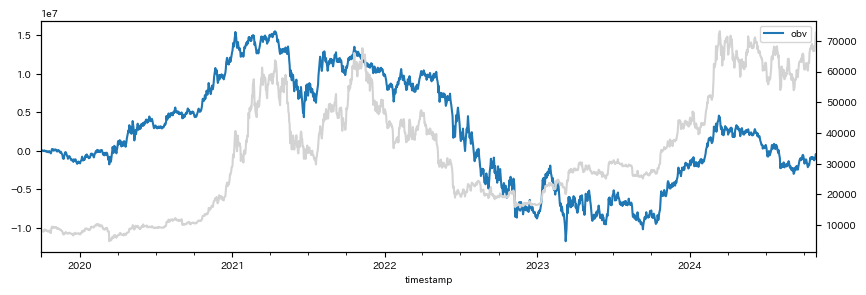

In [15]:
plt.figure(figsize=(10, 3))
strategy1['obv'].plot()
plt.legend()
strategy1['binance_close'].plot(ax=plt.gca().twinx(), color='lightgray');

## ストラテジー

- OBV値がEMAを上回ったときにロング、下回ったときショート。

In [16]:
# OBVのEMAを計算
ema_span = 20
strategy1['obv_ema'] = strategy1['obv'].ewm(span=ema_span).mean()

In [17]:
strategy1['signal'] = None
strategy1.loc[strategy1['obv'] > strategy1['obv_ema'], 'signal'] = 1
strategy1.loc[strategy1['obv'] < strategy1['obv_ema'], 'signal'] = -1
strategy1['signal'] = strategy1['signal'].shift(1)
strategy1['signal'] = strategy1['signal'].fillna(method='ffill')

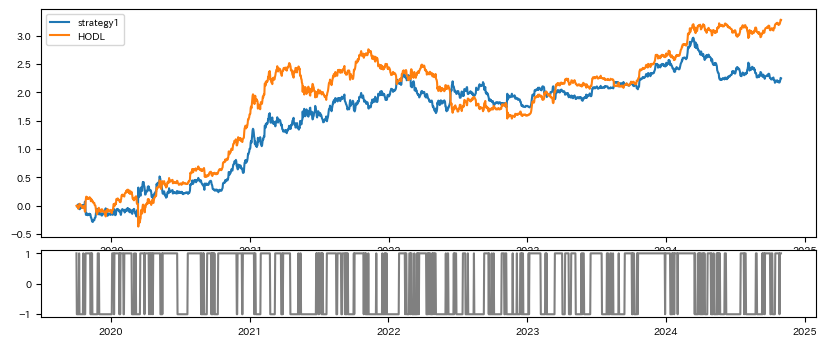

In [18]:
plt.figure(figsize=(10, 4))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.plot((strategy1['signal'] * strategy1['binance_ror']).cumsum(), label='strategy1')
ax.plot(strategy1['binance_ror'].cumsum(), label='HODL')
plt.legend()
ax = plt.subplot2grid((4, 1), (3, 0))
ax.plot(strategy1['signal'], color='gray')
plt.show();

# 出来高変化率（VROC）

- 出来高変化率（VROC）とは
  - 一定期間の出来高の変化率を数値化したもの。一種のモメンタム指標、とのこと。
  - VROCがプラスの場合は出来高が強気、マイナスの場合は出来高が弱気であることを示す。 

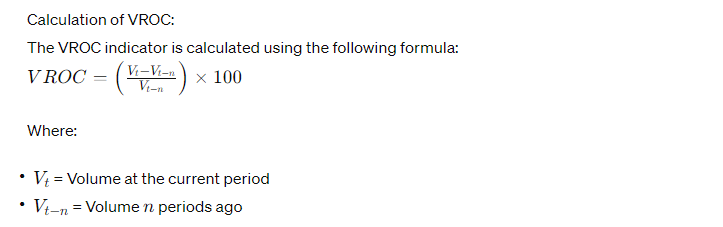

In [19]:
Image('./images/12_03_01.png', width=800)

## 指標の計算

In [20]:
strategy2 = btcusdt.copy()

In [21]:
n = 10
strategy2['vroc'] = strategy2['binance_volume'].pct_change(n)

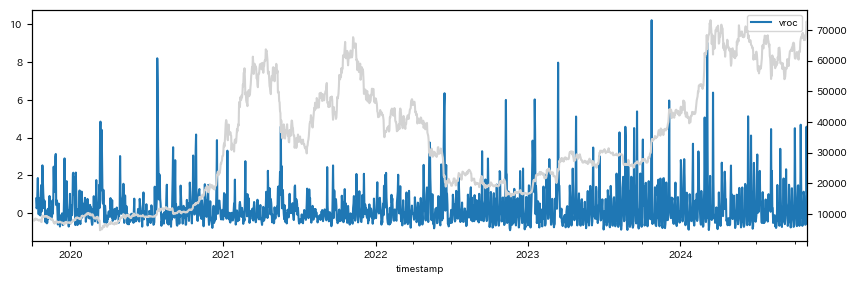

In [22]:
plt.figure(figsize=(10, 3))
strategy2['vroc'].plot()
plt.legend()
strategy1['binance_close'].plot(ax=plt.gca().twinx(), color='lightgray');

## ストラテジー

- VROCが移動平均線を上回ったときにロング、下回ったときショート。

In [23]:
sma_span = 10
strategy2['vroc_sma'] = strategy2['vroc'].rolling(sma_span).mean()

In [24]:
strategy2['signal'] = None
strategy2.loc[strategy2['vroc'] > strategy2['vroc_sma'], 'signal'] = 1
strategy2.loc[strategy2['vroc'] < strategy2['vroc_sma'], 'signal'] = -1
strategy2['signal'] = strategy2['signal'].shift(1)
strategy2['signal'] = strategy2['signal'].fillna(method='ffill')

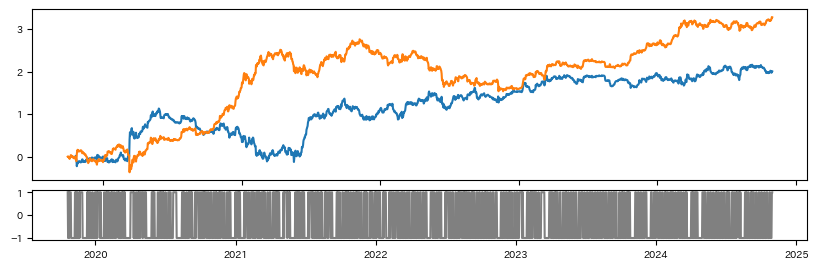

In [25]:
plt.figure(figsize=(10, 3))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.plot((strategy2['signal'] * strategy2['binance_ror']).cumsum())
ax.plot(strategy2['binance_ror'].cumsum())
ax = plt.subplot2grid((4, 1), (3, 0))
ax.plot(strategy2['signal'], color='gray')
plt.show();

- いったん指標についてはここまで。
- 指標単体でよいストラテジーを無理に作る必要はない。

- これらの指標は特徴量として機械学習モデルの構築などに利用できる。（例：リッチマンチュートリアルなど）

# オーバーフィッティングの確認

- オーバーフィッティングとは
  - 過去のデータに対してストラテジーのパラメータを過度に調整することによって、未来のデータに対する汎化性能を失ってしまうこと
  - 例）丸暗記。
  - パラメータが多い複雑なモデルはこの問題が発生しやすくなる。

- 今回の2番目のストラテジーは、パラメータは2つ。
  - VROCの変化率の計算期間 n（デフォルト10）
  - ストラテジーに利用する、VROCのSMA期間（デフォルト10）
- この2つのパラメータを1～100まで動かして、最もよいバックテスト結果が出たパラメータを採用する。

- バックテスト期間 2023年12月以前
- フォワードテスト期間 2024年1月以降

## パラメータをずらしながら成績を計算

In [26]:
df = btcusdt.copy()[:'2023-12']
result = {}

for n in range(1, 100):
    # n: 1～100
    for sma_span in range(1, 100):
        # sma_span: 1～100
        df['vroc'] = df['binance_volume'].pct_change(n)
        df['vroc_sma'] = df['vroc'].rolling(sma_span).mean()
        df['signal'] = None
        df.loc[df['vroc'] > df['vroc_sma'], 'signal'] = 1
        df.loc[df['vroc'] < df['vroc_sma'], 'signal'] = -1
        df['signal'] = df['signal'].shift(1)
        df['signal'] = df['signal'].fillna(method='ffill')
        result[f'{n}_{sma_span}'] = (df['signal'] * df['binance_ror']).sum()
result = pd.Series(result)
result

1_1      0.000000
1_2      0.644738
1_3      0.789597
1_4      0.777381
1_5      1.341560
           ...   
99_95   -1.730917
99_96   -1.742358
99_97   -1.687750
99_98   -1.764621
99_99   -1.686889
Length: 9801, dtype: float64

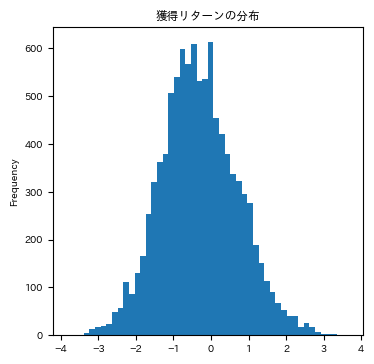

In [27]:
result.plot(kind='hist', bins=50, title='獲得リターンの分布');

## 順位表示

In [28]:
result.sort_values(ascending=False).head(10)

30_5     3.666793
72_3     3.297356
23_5     3.277597
43_7     3.167627
23_2     3.144918
47_2     2.975964
43_17    2.967161
30_54    2.832703
8_4      2.817961
38_2     2.806449
dtype: float64

## 最も成績のよかったパラメータのバックテスト成績をプロット

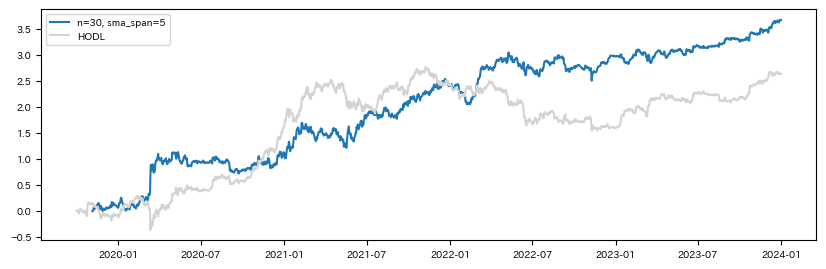

In [29]:
df = btcusdt.copy()[:'2023-12']
plt.figure(figsize=(10, 3))
for n, sma_span in [(30, 5)]:
    df['vroc'] = df['binance_volume'].pct_change(n)
    df['vroc_sma'] = df['vroc'].rolling(sma_span).mean()
    df['signal'] = None
    df.loc[df['vroc'] > df['vroc_sma'], 'signal'] = 1
    df.loc[df['vroc'] < df['vroc_sma'], 'signal'] = -1
    df['signal'] = df['signal'].shift(1)
    df['signal'] = df['signal'].fillna(method='ffill')
    plt.plot((df['signal'] * df['binance_ror']).cumsum(), label=f'n={n}, sma_span={sma_span}')
plt.plot(df['binance_ror'].cumsum(), color='lightgray', label='HODL')
plt.legend();

## フォワード期間の生成をプロット

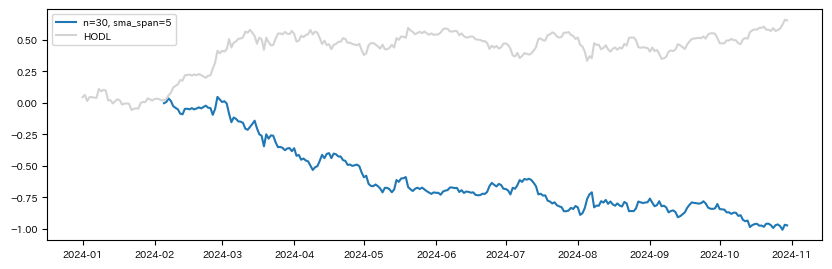

In [30]:
df = btcusdt.copy()['2024':]
plt.figure(figsize=(10, 3))
for n, sma_span in [(30, 5)]:
    df['vroc'] = df['binance_volume'].pct_change(n)
    df['vroc_sma'] = df['vroc'].rolling(sma_span).mean()
    df['signal'] = None
    df.loc[df['vroc'] > df['vroc_sma'], 'signal'] = 1
    df.loc[df['vroc'] < df['vroc_sma'], 'signal'] = -1
    df['signal'] = df['signal'].shift(1)
    df['signal'] = df['signal'].fillna(method='ffill')
    plt.plot((df['signal'] * df['binance_ror']).cumsum(), label=f'n={n}, sma_span={sma_span}')
plt.plot(df['binance_ror'].cumsum(), color='lightgray', label='HODL')
plt.legend();

## 全体をプロット

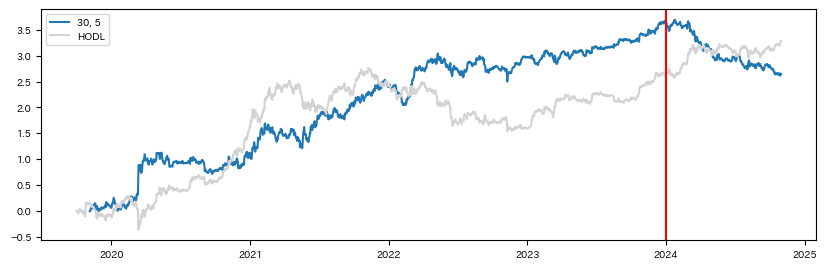

In [31]:
df = btcusdt.copy()
plt.figure(figsize=(10, 3))
for n, sma_span in [(30, 5)]:
    df['vroc'] = df['binance_volume'].pct_change(n)
    df['vroc_sma'] = df['vroc'].rolling(sma_span).mean()
    df['signal'] = None
    df.loc[df['vroc'] > df['vroc_sma'], 'signal'] = 1
    df.loc[df['vroc'] < df['vroc_sma'], 'signal'] = -1
    df['signal'] = df['signal'].shift(1)
    df['signal'] = df['signal'].fillna(method='ffill')
    plt.plot((df['signal'] * df['binance_ror']).cumsum(), label=f'{n}, {sma_span}')
plt.plot(df['binance_ror'].cumsum(), color='lightgray', label='HODL')
plt.axvline(pd.to_datetime('2024-01-01'), color='red')
plt.legend();

# まとめ

- OHLCVを利用したテクニカル指標の作り方を勉強した。
- これらの指標単体でのストラテジーを作成し、損益曲線を確認した。
- テクニカル指標をパラメータチューニングしたときのオーバーフィッティングを確認した。

# 下書き

## ネガティブボリュームインデックス


1930 年代にポール・ダイサートが「スマートマネー」が活発な時期を検出することを目的として作成した累積指標。

取引量が少なく価格がプラスに変動する日には上昇し、取引量が少なく価格がマイナスに変動する日には下落し、取引量が多い日には中立のままです。

以下は、NVI の手数料とスリッページを含む簡単なバックテストです。

価格が安値を更新したが、同時に NVI が安値を更新した場合など、価格と NVI の間に乖離がある場合にロングポジションに入ります。

X 個のバーの後に終了します。


In [84]:
strategy3 = btcusdt.copy()

NVIの計算方法は次のとおりです。
昨日のNVIを取得する
今日の出来高が昨日の出来高よりも低い場合は、{（今日の終値 - 昨日の終値）/ 昨日の終値} * 昨日のNVIを加算する
そうでない場合は、0を加算する

In [89]:
strategy3['nvi'] = 1
strategy3.loc[strategy3['binance_volume'].shift(1) > strategy3['binance_volume'], 'nvi'] = (strategy3['binance_close'] - strategy3['binance_close'].shift(1)) / strategy3['binance_close'].shift(1) + 1
strategy3['nvi_cumprod'] = strategy3['nvi'].cumprod()

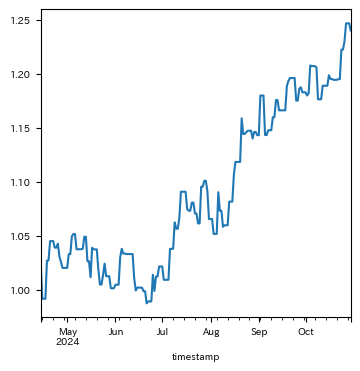

In [94]:
strategy3['nvi'][-200:].cumprod().plot();

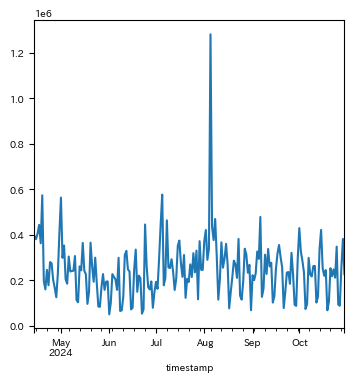

In [95]:
strategy3['binance_volume'][-200:].plot();

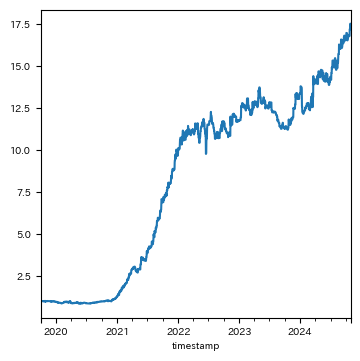

In [91]:
strategy3['nvi_cumprod'].plot();

In [ ]:
以下は、NVI の手数料とスリッページを含む簡単なバックテストです。

価格が安値を更新したが、同時に NVI が安値を更新した場合など、価格と NVI の間に乖離がある場合にロングポジションに入ります。

X 個のバーの後に終了します。


In [82]:
strategy2['signal'] = None
strategy2.loc[strategy2['vroc'] > strategy2['vroc_sma10'], 'signal'] = 1
strategy2.loc[strategy2['vroc'] < strategy2['vroc_sma10'], 'signal'] = -1
strategy2['signal'] = strategy2['signal'].shift(1)
strategy2['signal'] = strategy2['signal'].fillna(method='ffill')

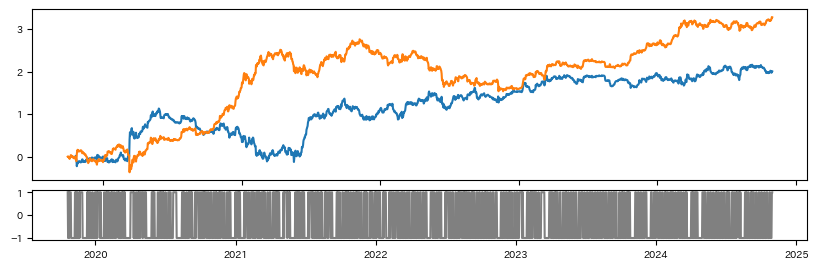

In [83]:
plt.figure(figsize=(10, 3))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.plot((strategy2['signal'] * strategy2['binance_ror']).cumsum())
ax.plot(strategy2['binance_ror'].cumsum())
ax = plt.subplot2grid((4, 1), (3, 0))
ax.plot(strategy2['signal'], color='gray')
plt.show();